In [1]:
import numpy as np
from numba import guvectorize,float32,vectorize
from numba import cuda
import math
import matplotlib.pyplot as plt
FOV = np.pi/4
SAMPLES = 5
RADIUS = 5
angles = np.linspace(-FOV, FOV, SAMPLES)
domain = np.random.random((1920,1080)).astype(np.float32)
ants = np.array([[0,0,0],[1,1,1]],dtype = np.float32)
deltas_buffer = np.zeros((len(ants),), dtype=np.float32)

In [6]:
@guvectorize(['float32[:,:],float32[:,:],float32[:]'],"(n,m),(k,l) -> (k)")
def wanted_direction_deltas(domain, ants,buffer):
    global angles
    for n, (x, y, a) in enumerate(ants):
        xs = (x + np.cos(angles+a) * RADIUS).astype(np.int32)
        ys = (y + np.sin(angles+a) * RADIUS).astype(np.int32)
        m = domain[xs[0],ys[0]]
        mi = 0
        for i,(x,y) in enumerate(zip(xs,ys)):
            if domain[x,y] > m:
                m = domain[x,y]
                mi = i
        buffer[n] = angles[mi]
wanted_direction_deltas(domain,ants)

float32 float32


array([0.7853982, 0.       ], dtype=float32)

In [ ]:
img = domain
@vectorize(["float32(int32,int32)"], target='cuda')
def conv2d(x, y):
    if x == 0 or y == 0 or x == img.shape[0]-1 or y == img.shape[1]-1:
        return 0
    
    result = domain[x, y]

    result += domain[x+1, y-1]
    result += domain[x+1, y]
    result += domain[x+1, y+1]

    result += domain[x, y-1]
    result += domain[x, y+1]

    result += domain[x-1, y-1]
    result += domain[x-1, y]
    result += domain[x-1, y+1]

    result /= 9
    # result = (result*DIFFUSION + domain[x, y]
    #                 * (1-DIFFUSION))*FADE_PER_STEP
    return result
#X,Y = np.meshgrid(np.arange(img.shape[0]),np.arange(img.shape[1]))
#conv2d(X,Y)

In [11]:
DIFFUSION = 0.5
FADE_PER_STEP = 0.98
@cuda.jit
def conv2d(domain,output):
    x, y = cuda.grid(2)
    
    if x == 0 or y == 0 or x == domain.shape[0]-1 or y == domain.shape[1]-1:
        return
    
    result = domain[x, y]

    result += domain[x+1, y-1]
    result += domain[x+1, y]
    result += domain[x+1, y+1]

    result += domain[x, y-1]
    result += domain[x, y+1]

    result += domain[x-1, y-1]
    result += domain[x-1, y]
    result += domain[x-1, y+1]

    result /= 9
    result = (result*DIFFUSION + domain[x, y]
                    * (1-DIFFUSION))*FADE_PER_STEP
    output[x,y] = result

C:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\numba\cuda\cudadrv\devicearray.py:790: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Wall time: 281 ms
Wall time: 33 ms
Wall time: 30.5 ms
Wall time: 31.5 ms
Wall time: 31.1 ms
Wall time: 24.6 ms


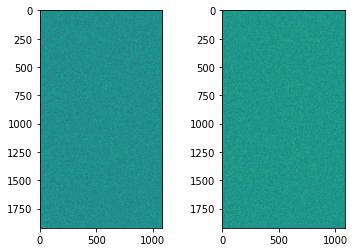

In [12]:
output = np.zeros_like(domain)

per_thread = 1

threadsperblock = (8, 16)
blockspergrid_x = math.ceil(domain.shape[0] / threadsperblock[0]/per_thread)
blockspergrid_y = math.ceil(domain.shape[1] 
/ threadsperblock[1]/per_thread)
blockspergrid = (blockspergrid_x, blockspergrid_y)

%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
%time conv2d[blockspergrid, threadsperblock](domain,output)
plt.subplot(1,2,1)
plt.imshow(domain)
plt.subplot(1,2,2)
plt.imshow(output)
plt.show()

In [15]:
import sys
import itertools
sys.getsizeof(domain)

8294512

In [13]:
from numba import cuda
import numpy as np
FOV = np.pi/4
SAMPLES = 3
# resolution
WIDTH = 1920
HEIGHT = 1080

# movement speed of the ants per step
SPEED = 1.5

# ants will be "reflected" EDGE_WIDTH  pixels before reaching the border of the domain.
# used so that the "sensing" of the ants does not cause an out of bounds are
EDGE_WIDTH = 25

# distance at which the ants sample the phermone density
RADIUS = 25

look_angles = np.linspace(-FOV, FOV, SAMPLES)
look_rotations = np.array([[np.cos(a), -np.sin(a), np.sin(a), np.cos(a)]
                          for a in look_angles], dtype=np.float32)
@cuda.jit
def step_cuda(domain,view,ants):
    global look_rotations
    n = cuda.grid(1)
    
    if n >= len(ants):
        return

    # for every ant
    (x, y, vx, vy) = ants[n]
    m = -1
    vxd = 0
    vyd = 0
    # find the highest pheromone concentration ahead
    for a, b, c, d in look_rotations:
        # rotation via precalculated rotation matrices
        vxn = vx*a+vy*c
        vyn = vx*b+vy*d
        x_int = int(x + vxn * RADIUS)
        y_int = int(y + vyn * RADIUS)
        if view[x_int, y_int] > m:
            m = view[x_int, y_int]
            vxd = vxn
            vyd = vyn

    # update the velocities and positions
    ants[n, 2] = vxd
    ants[n, 3] = vyd
    ants[n, 0] += ants[n, 2]*SPEED
    ants[n, 1] += ants[n, 3]*SPEED

    # bounce ants of domain bounds
    if ants[n, 0] < EDGE_WIDTH:
        ants[n, 0] = EDGE_WIDTH
        ants[n, 2] = - ants[n, 2]

    if ants[n, 0] >= WIDTH - EDGE_WIDTH:
        ants[n, 0] = WIDTH-1 - EDGE_WIDTH
        ants[n, 2] = - ants[n, 2]

    if ants[n, 1] < EDGE_WIDTH:
        ants[n, 1] = EDGE_WIDTH
        ants[n, 3] = - ants[n, 3]

    if ants[n, 1] >= HEIGHT-EDGE_WIDTH:
        ants[n, 1] = HEIGHT - 1 - EDGE_WIDTH
        ants[n, 3] = - ants[n, 3]

    # increase pheromone concentration at ants position
    cx, cy = int(ants[n, 0]), int(ants[n, 1])
    domain[cx, cy] += 1

In [4]:
domain = np.zeros((WIDTH, HEIGHT), dtype=np.float32)
N = 1_000_000
def spawn_ants_in_circle(count, radius, center):
    # uniform random positions in a circle for ants
    position_angles = np.random.uniform(0, np.pi*2, (count,))
    # rescaling to ensure uniform distribution
    lengths = np.sqrt(np.random.uniform(0, radius**2, (count,)))
    xs = lengths * np.cos(position_angles) + center[0]
    ys = lengths * np.sin(position_angles) + center[1]

    # velocities for all ants
    direction_angles = np.random.uniform(0, np.pi*2, (count,))
    vxs = np.cos(direction_angles)
    vys = np.sin(direction_angles)
    ants = np.array([xs, ys, vxs, vys]).T
    return ants.astype(np.float32)

# smallest domain size, considering EDGEWIDTH
min_dir = min(HEIGHT, WIDTH)-2*EDGE_WIDTH
ants = spawn_ants_in_circle(N, min_dir/2, (WIDTH/2, HEIGHT/2))

In [18]:
per_thread = 1

threadsperblock = 128
blockspergrid = int(np.ceil(N/threadsperblock/per_thread))

%time step_cuda[blockspergrid, threadsperblock](domain,domain,ants)
%time step_cuda[blockspergrid, threadsperblock](domain,domain,ants)

Wall time: 38 ms
Wall time: 34 ms
